## Intro

This is an example notebook of my workflow in recommendation system. The example data is about users rating movies, but the same techniques can be applied to search engines results, store product recommendations, book recommendations etc.

**Purpose:** showcase skills and knowledge in building an effective recommendation system from scratch.

**Inputs:**  
The data is from Movielens "small" dataset, which is only 1Mb and contains "100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018." https://grouplens.org/datasets/movielens/
- ratings.csv, contains the movie ratings of several hundred users. Users are anonymous and movies are also referred as IDs.
- movies.csv, contains the corresponding movie ID mapping, with movie titles, years and genres.
- test_ratings.csv, contains one additional user and his movie ratings. (not included in Movielens dataset)

The goal is to build a recommandtion model, and then based on a test user's data, recommend him 10 new movies.

In this example I show two user-to-user collaborative filtering algorithms, which will match the users' preferences and recommend movies based on what similar users like. The algorithms are:
1. Simple way with Nearest neighbours algorithm, which finds similar users and works well for small datasets. 
2. More advanced way with sparce matrix construction and Alternating least squares algorithm for bigger datasets.

## Part 1: Simple way for small dataset

In the simple way we use Nearest neighbours algorithm. It simply calculates the distances of each rating to each other. For example, user A has rated movies X, and Y with scores 2,2 and user B has rated the same movies with 4,5. Now, if user C has only seen the movie X and rated it 5 we can calculate his distance to users A and B, and use this to predict what score would movie Y get from him. Since user B has rated movie X with 4, he is closer (or more similar) to user C than to user A who gave movie X a 2. Therefore, the rating prediction of movie Y is quite high for user C.

### Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

In [2]:
%%time
ratings = pd.read_csv("data/06 - Recommendation System/ratings.csv")
ratings

CPU times: total: 31.2 ms
Wall time: 34.9 ms


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [3]:
ratings = ratings.drop("timestamp",axis=1)

This dataset contains about 100 000 ratings. The ratings dataframe contains the user id, movie id, the user's rating for that movie and a timestamp of the rating. The timestamp is not needed and can be removed

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


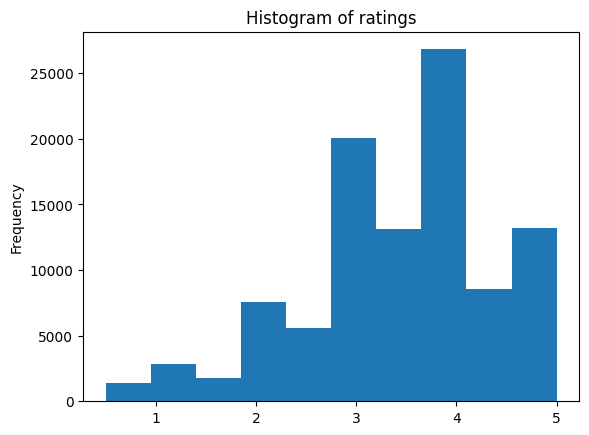

In [4]:
ratings.rating.plot.hist(title="Histogram of ratings")
print(ratings.rating.describe())

In [5]:
print(f"Average number of movies rated per user: {len(ratings.movieId.unique())/len(ratings.userId.unique())}")

Average number of movies rated per user: 15.940983606557378


In [6]:
print(f"The most common score is {ratings.rating.mode().values[0]}")

The most common score is 4.0


Each user has rated about 16 users and the ratings vary from 0.5 to 5. The average of all scores is 3.5, but the most common score is 4.

In [7]:
movies = pd.read_csv("data/06 - Recommendation System/movies.csv")

movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


The movies data can be used to find the movie title based on the movie id. Since we don't use its data in the recommendation process, we don't need to touch it now. However, it might also be interesting to analyse the genres of the movies the users like.

In [8]:
test = pd.read_csv("data/06 - Recommendation System/test_ratings.csv")
test

,movie_id,imdb_id,tmdb_id,rating,average_rating,title
0,1,114709,862,3.0,3.89332,Toy Story (1995)
1,6,113277,949,3.0,3.86419,Heat (1995)
2,29,112682,902,3.5,3.91111,The City of Lost Children (1995)
3,32,114746,63,4.0,3.89635,Twelve Monkeys (1995)
4,47,114369,807,3.5,4.08830,Se7en (1995)
...,...,...,...,...,...,...
411,254726,1160419,438631,2.5,3.96473,Dune (2021)
412,263405,7740496,597208,2.0,3.43943,Nightmare Alley (2021)
413,270698,6710474,545611,5.0,4.07251,Everything Everywhere All at Once (2022)
414,275167,12477480,705996,4.0,3.66051,Decision to Leave (2022)


This is our test user and his ratings. Based on these and other people's ratings, the goal is to recommend him 10 new movies.

Let's rename the movie_id column to match the training data, and drop all other columns than rating.

In [9]:
test = test.rename(columns={"movie_id":"movieId"})
test = test[["movieId","rating"]].set_index("movieId")
test

,rating
movieId,
1,3.0
6,3.0
29,3.5
32,4.0
47,3.5
...,...
254726,2.5
263405,2.0
270698,5.0


For Nearest neighbours algorithm we need to transform the ratings to a table where each row is a movie, each column is the user and cell values are the scores the users gave them. Since most users haven't rated all the movies, some cell values are empty. The algorithm doesn't accept NaNs, so let's fill those with 0's.

In [10]:
%%time
ratings_pivot = pd.pivot_table(ratings,index="movieId",columns="userId",values="rating",fill_value=0)
ratings_pivot

CPU times: total: 328 ms
Wall time: 329 ms


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4,0.0,0.0,0,4,0,4.5,0,0,0.0,...,4.0,0,4,3,4.0,2.5,4,2.5,3,5.0
2,0,0.0,0.0,0,0,4,0.0,4,0,0.0,...,0.0,4,0,5,3.5,0.0,0,2.0,0,0.0
3,4,0.0,0.0,0,0,5,0.0,0,0,0.0,...,0.0,0,0,0,0.0,0.0,0,2.0,0,0.0
4,0,0.0,0.0,0,0,3,0.0,0,0,0.0,...,0.0,0,0,0,0.0,0.0,0,0.0,0,0.0
5,0,0.0,0.0,0,0,5,0.0,0,0,0.0,...,0.0,0,0,3,0.0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0,0.0,0.0,0,0,0,0.0,0,0,0.0,...,0.0,0,0,0,0.0,0.0,0,0.0,0,0.0
193583,0,0.0,0.0,0,0,0,0.0,0,0,0.0,...,0.0,0,0,0,0.0,0.0,0,0.0,0,0.0
193585,0,0.0,0.0,0,0,0,0.0,0,0,0.0,...,0.0,0,0,0,0.0,0.0,0,0.0,0,0.0


In [11]:
# Choose number of neighbours to consider in finding similar N movies.
n_neighbors = 15
n_top_movies = 10

# Fitting model with cosine metric. Since we want to search similar users, let's use transposed ratings_pivot
nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute',n_jobs=-1)
nn_model.fit(ratings_pivot.T)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=15)

In [12]:
# Create a dataframe of similar format for the new user
all_movies = ratings_pivot.index
new_user_data = pd.DataFrame(0, columns=all_movies, index=[0]).T
new_user_data.columns = ["rating"]

# Update the new dataframe with the test user's ratings
new_user_data.update(test["rating"])
new_user_data

,rating
movieId,
1,3.0
2,0.0
3,0.0
4,0.0
5,0.0
...,...
193581,0.0
193583,0.0
193585,0.0


In [13]:
# Find the distances and indices of the nearest neighbors for the new user based on his data
distance_to_neighbor, neighbor_indices = nn_model.kneighbors(new_user_data.T, n_neighbors=n_neighbors)

In [14]:
# The resulting top 15 nearest users and their distance
pd.DataFrame([neighbor_indices[0],distance_to_neighbor[0]],index=["userIdIndex","distance"]).T

,userIdIndex,distance
0,246.0,0.517033
1,61.0,0.568963
2,304.0,0.580921
3,433.0,0.581276
4,559.0,0.587310
5,482.0,0.589145
6,232.0,0.591719
7,278.0,0.593039
8,17.0,0.594747
9,211.0,0.595235


In [15]:
# The ratings of the nearest neighbors
nearest_neighbor_ratings = ratings_pivot.iloc[:, neighbor_indices[0]]
nearest_neighbor_ratings

userId,247,62,305,434,560,483,233,279,18,212,328,601,352,339,610
movieId,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,4.0,3.0,4.0,3.0,3.0,3.5,0.0,5.0,4.0,0.0,4.0,5.0
2,0.0,4.0,3.5,2.5,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We want a weighed average of the ratings, depending on the distance (if the user is closer, their ratings are taken more into account in the final scoring). The distances range from 0 to 1, where 0 means closer to the test user. Therefore we need to invert the distance. I also scaled it based on the nearest distance, so that the scores of the nearest user is multiplied by 1 and the remaining users' scores are multiplied with values smaller than one.

In [16]:
# Compute the weights for each user
dist_invert = 1-distance_to_neighbor[0]
max_dist = max(dist_invert)
scaled_distances = dist_invert/max_dist
scaled_distances

array([1.        , 0.89247793, 0.86771677, 0.86698337, 0.85448843,
       0.85069044, 0.84536002, 0.84262695, 0.83909101, 0.83807894,
       0.83404697, 0.82641649, 0.81230726, 0.81098076, 0.80885626])

In [17]:
# Calculate the weighted ratings for all movies
unrated_movies = new_user_data[new_user_data.rating==0].index
weighted_ratings = (nearest_neighbor_ratings*scaled_distances).mean(axis=1)  # Weighted average of ratings from neighbors
weighted_ratings

movieId
1         2.479936
2         0.979628
3         0.000000
4         0.000000
5         0.141782
            ...   
193581    0.000000
193583    0.000000
193585    0.000000
193587    0.000000
193609    0.000000
Length: 9724, dtype: float64

In [18]:
# Sort the unrated movies by weighted ratings and recommend the top N
top_movies = weighted_ratings[unrated_movies].sort_values(ascending=False).head(n_top_movies)

print(f"Top {n_top_movies} recommended movies for the new user:")
for i, movie in enumerate(top_movies.index):
    print(i+1, movies[movies.movieId==movie].title.values[0])

Top 10 recommended movies for the new user:
1 Departed, The (2006)
2 Star Wars: Episode V - The Empire Strikes Back (1980)
3 Iron Man (2008)
4 Fargo (1996)
5 Star Wars: Episode VI - Return of the Jedi (1983)
6 Bourne Ultimatum, The (2007)
7 Hangover, The (2009)
8 Bourne Identity, The (2002)
9 Terminator 2: Judgment Day (1991)
10 Titanic (1997)


At this point I can reveal that the movie scores are my ratings from the Movielens website. The list of recommended movies has some movies that I'm interested in watching, but overall they all are really popular movies since the training data only contained 600 users and 100 000 ratings. I'd like to get more accurate results by using a bigger dataset, which is exactly what we do in part 2 of this notebook.

But before we do that, let's just check how well the closest user matches my ratings. From the shortest distance (0.526455) we can see that the closest user is quite far away (number close to 1 would match me well). Let's see how many movies he has rated and how many have both of us seen. 

In [19]:
top_match = ratings_pivot.iloc[:, neighbor_indices[0][0]]
top_match_df = pd.DataFrame(top_match[top_match>0]).reset_index()
top_match_df.columns = ["movieId","rating_top_match"]
common_films = pd.merge(top_match_df,test.reset_index())
common_films['movie'] = common_films['movieId'].map(movies.set_index('movieId')['title'])
common_films[["rating_top_match","rating"]] = common_films[["rating_top_match","rating"]].astype(float)
print(f"Top match has rated {len(top_match[top_match>0])} movies, and {len(common_films)} are in common with test user:")
common_films

Top match has rated 150 movies, and 112 are in common with test user:


,movieId,rating_top_match,rating,movie
0,1,5.0,3.0,Toy Story (1995)
1,32,3.0,4.0,Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
2,47,4.0,3.5,Seven (a.k.a. Se7en) (1995)
3,50,5.0,4.0,"Usual Suspects, The (1995)"
4,110,4.0,3.5,Braveheart (1995)
...,...,...,...,...
107,122904,3.0,2.0,Deadpool (2016)
108,134130,4.0,3.5,The Martian (2015)
109,136864,2.5,1.0,Batman v Superman: Dawn of Justice (2016)
110,139385,5.0,2.0,The Revenant (2015)


In [20]:
# Function for adding some jitter to scatterplot results
def some_jitter(data):
    stdev = .015 * (max(data) - min(data))
    return data + np.random.randn(len(data)) * stdev

Text(0.5, 1.0, "My ratings vs best match's rating")

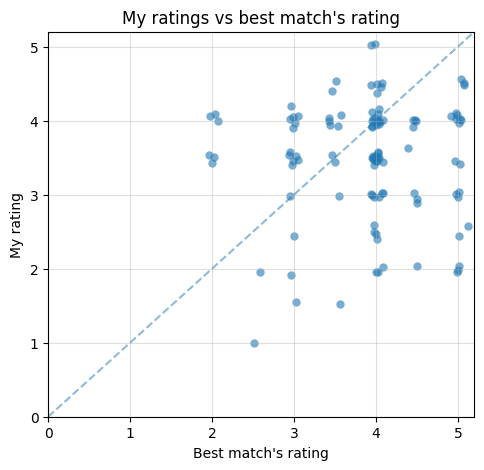

In [21]:
plt.figure(figsize=(5.5,5))
plt.scatter(some_jitter(common_films["rating_top_match"]),
            some_jitter(common_films["rating"]),
            alpha=0.6, lw=0)
plt.xlim(0,5.2)
plt.ylim(0,5.2)
plt.ylabel("My rating")
plt.xlabel("Best match's rating")
plt.grid(alpha=0.4)
plt.gca().axline((1, 1), slope=1,ls="--",alpha=0.5)
plt.title("My ratings vs best match's rating")

We can see that generally both of us tended to rate movies with ratings of 3-5. We mostly agree on many movies that we gave 4 to, but not so many others. Majority of the movies is +-1 of each others' ratings, but there are some that I rated lowly but he rated with high scores.

## Part 2: advanced recommendation method for bigger dataset

If we want to use a bigger dataset, for example the 25M dataset from Movielens, we need to use some other methods. Using nearest neighbours has (at least) two problems:
1. Generally these kind of algorithms that calculate distances to every other point needs to iterate through the whole list against the whole list. Therefore, its running time is at least O(n^2). 
2. The 25M dataset is 650Mb big and has 25 000 000 ratings. Creating a similar pivot_table like in Part 1 would need 70Gb of RAM to store, which isn't feasible. 

Big datasets like these are common in real world, so there have been other clever ways to manipulate them and calculate recommendations without comparing every single rating and user to each other.

In this example we use two techniques:
1. Space matrix instead of full pivot table to reduce the dimensionality of the dataset
2. Alternating least squares algorithm to find predictions for new users

In [22]:
from scipy.sparse import csr_matrix
from sys import getsizeof
from implicit.als import AlternatingLeastSquares

### Space matrix
Sparce matrices are a way to encode big datasets into smaller sized arrays. For this problem and efficient computation, let's use Compressed Sparce Row (CSR) matrix. 

CSR works by mapping a datatable into three arrays: the indices, the index pointers and the data values. For example, if we have three users who have rated three movies in the following way: 

In [23]:
example_table = pd.DataFrame([[4,5,0],[0,0,0],[0,3,1]],columns=["movie1","movie2","movie3"])
example_table

,movie1,movie2,movie3
0,4,5,0
1,0,0,0
2,0,3,1


Turning this into CSR matrix results in:

In [24]:
example_csr = csr_matrix(example_table)
print(example_csr.indptr)
print(example_csr.indices)
print(example_csr.data)

[0 2 2 4]
[0 1 1 2]
[4 5 3 1]


The first row, the index pointers, is the most confusing, so let's go through the other rows first. The second row, the indices, tells us the column (movie) number. The third row, the data, tells us the scores. 

The values of first row work in pairs, reading from the left. Each pair is a new row (userId), meaning the length of the index pointers array is len(userId)+1. Each pair tells us, for that user, the slice of the indices (movies) and data (ratings) array. 

For example, the first pair [0,2] says that the first user rated movies at positions 0 and 1 of the indices array and gave them scores at positions 0 and 1 of the data array. These correspond to columns 0 and 1 of the example_table (movie1 and movie2) and scores of 4 and 5 (row 0 of example_table). Continuing to the right, the second pair [2,2] tells us that the second user didn't rate any movies. The third pair [2,4] tells us that the third user also rated 4-2=2 movies at positions 2 and 3. These correspond to columns (indices) 1 and 2 and ratings (data) 3 and 1.

The CSR matrix of this small example actually turned out to be bigger than the original example_table, but when the size grows the CSR-matrix outperforms dense matrices in speed and memory.

In [25]:
%%time
ratings = pd.read_csv("C:/Users/Anton/Downloads/ml-25m/ratings.csv").drop("timestamp",axis=1)
ratings

CPU times: total: 6.81 s
Wall time: 6.81 s


,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5
...,...,...,...
25000090,162541,50872,4.5
25000091,162541,55768,2.5
25000092,162541,56176,2.0
25000093,162541,58559,4.0


In [26]:
movies = pd.read_csv("C:/Users/Anton/Downloads/ml-25m/movies.csv")
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [27]:
test = pd.read_csv("data/ml-latest-small/test_ratings.csv")
test = test.rename(columns={"movie_id":"movieId"})
test = test[["movieId","rating"]]
test_userId = max(ratings.userId)+1 # create a new userId for test user
test["userId"] = [test_userId]*len(test)
test

,movieId,rating,userId
0,1,3.0,162542
1,6,3.0,162542
2,29,3.5,162542
3,32,4.0,162542
4,47,3.5,162542
...,...,...,...
411,254726,2.5,162542
412,263405,2.0,162542
413,270698,5.0,162542
414,275167,4.0,162542


In [28]:
# The dataset is couple years old, so some of the movies
# the test user has rated are not on the list. Remove them.
movies_not_in_database = []

movielist = movies.movieId.unique()
for rated_movie in test.movieId.unique():
    if rated_movie not in movielist:
        movies_not_in_database.append(rated_movie)

print(movies_not_in_database)

indices_to_drop = test[test.movieId.isin(movies_not_in_database)].index
test = test.drop(indices_to_drop)

[209315, 210851, 210861, 213397, 218537, 220380, 221576, 223204, 225173, 226202, 228099, 244178, 250010, 253690, 254726, 263405, 270698, 275167, 278446]


In [29]:
ratings_con = pd.concat([ratings,test],ignore_index=True)
ratings_con[["userId","movieId"]] = ratings_con[["userId","movieId"]].astype('category')
ratings_con

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5
...,...,...,...
25000487,162542,204158,4.0
25000488,162542,204698,4.5
25000489,162542,204710,4.0
25000490,162542,206857,2.0


In [30]:
# create a sparse matrix using the (rating, (rows, cols)) format
# rows and cols need to be categorical
userId_cat = ratings_con["userId"].cat.codes
movieId_cat = ratings_con["movieId"].cat.codes
rating = ratings_con["rating"]
rating_user_movie = csr_matrix((rating, (userId_cat, movieId_cat)))
rating_user_movie

<162542x59047 sparse matrix of type '<class 'numpy.float64'>'
	with 25000492 stored elements in Compressed Sparse Row format>

A [25,000,901 x 3]-sized matrix was turned into a  [162,542 x 59,047] sparse matrix. Sparce matrix is technically only 3 vectors, the indices, the index pointers and the data values. Let's see how much memory both matrices take.

In [31]:
getsizeof(ratings)

600002424

In [32]:
getsizeof(rating_user_movie)

48

The dataframe "ratings" takes 600 Mb of memory, whereas "rating_csr" takes only 48 bytes!

In [33]:
print(rating_user_movie.indptr)
print(rating_user_movie.indices)
print(rating_user_movie.data)

[       0       70      254 ... 24999913 25000095 25000492]
[  292   302   303 ... 57657 58416 58578]
[5.  3.5 5.  ... 4.  2.  4. ]


Just to make sure that the number of unique movie IDs match the length (and last index) of the CSR-matrix indices.

In [34]:
%%time
print(max(rating_user_movie.indices))
print(len(ratings.movieId.unique()))

59046
59047
CPU times: total: 1.14 s
Wall time: 1.14 s


Since the indices start from 0, the numbers match. 

Same check for the user ids. Since each pair of pointers refers to one user, there should be one more pointer than userId.

In [35]:
%%time
print(len(rating_user_movie.indptr))
print(len(ratings.userId.unique()))

162543
162541
CPU times: total: 172 ms
Wall time: 177 ms


## Alternating least squares
There are several algorithms for finding recommendations based on existing data. Here we are using Alternating least squares, that works in the following way:

Based on the available users and their ratings on several products, ALS tries to find two matrices U and P who when multiplied fits the original matrix the best. It computers U first by minimizing the least squares error while keeping P fixed, then it tries to computer P while keeping U fixed and so on, hence the "alternating" in the name. This is repeated for enough iterations so that the values converge. After this, any missing value for each user can be computed.

There is a good introduction and example of ALS at https://sophwats.github.io/2018-04-05-gentle-als.html
<img src="https://sophwats.github.io/images/Factored.png" alt="ALS example from sophwats" style="width: 500px;"/>

In [36]:
# Initialize the ALS model and fit it
model = AlternatingLeastSquares(factors=150, iterations=25, calculate_training_loss=True)
model.fit(rating_user_movie)

  0%|          | 0/25 [00:00<?, ?it/s]

In [37]:
# For recommendation we need a matrix of only the test user's ratings.
# The index of the test user is the index of his position in the unique userId list.
test_user_idx = list(ratings_con.userId.unique()).index(test_userId)
test_user_data = rating_user_movie[test_user_idx]
test_user_data

<1x59047 sparse matrix of type '<class 'numpy.float64'>'
	with 397 stored elements in Compressed Sparse Row format>

In [38]:
print(test_user_data.indptr)
print(test_user_data.indices)
print(test_user_data.data)

[  0 397]
[    0     5    28    31    46    49   108   109   121   250   257   285
   289   292   314   351   359   475   522   536   545   580   585   587
   725   734   762   840   882   883   887   891   898   902   903  1012
  1047  1053  1062  1108  1147  1164  1167  1168  1169  1170  1171  1173
  1174  1176  1177  1182  1183  1188  1190  1191  1194  1205  1225  1227
  1232  1237  1245  1249  1258  1475  1523  1533  1591  1620  1640  1666
  1678  1795  1818  1871  1872  1879  1893  1921  1930  1939  1987  1992
  2025  2034  2084  2197  2200  2238  2304  2411  2451  2480  2600  2620
  2624  2638  2669  2670  2699  2766  2867  2905  2908  2928  2941  2988
  2990  3021  3054  3379  3436  3479  3570  3845  3890  3892  3907  3912
  4122  4201  4203  4265  4615  4742  4772  4780  4790  4867  4873  4887
  4889  4920  4958  5337  5508  5562  5579  5704  5766  5770  5840  5844
  5859  5877  5883  5904  6238  6258  6379  6416  6588  6751  6822  6897
  6965  7022  7028  7129  7236  7248  729

test_user_data contains only the test user's ratings. The pointers show that the ratings are between indices 0 and 387, the indices show the category-mapped movieIds and the data itself is the rating for each movie.

In [39]:
# Use the model to acquire 10 recommendations
rec = model.recommend(test_user_idx, test_user_data, N=10)
red_df = pd.DataFrame(rec,index=["movieId_premap","score"]).T
red_df

,movieId_premap,score
0,1175.0,1.158764
1,12594.0,0.919914
2,18720.0,0.881771
3,3923.0,0.870298
4,6974.0,0.859613
5,1566.0,0.840143
6,11433.0,0.839996
7,7018.0,0.836202
8,41754.0,0.828029
9,18114.0,0.824019


Now we have the top 10 recommended movies. The recommended movie_id_premap-values are in the form of categorized mapping, meaning they run from 1 to 59047. However, the movieIds on the ratings list are 59047 different values between 1 and 209171. There are gaps in the IDs, for example movies no one has rated. Therefore, we need to map the recommended values to the movieId of ratings. 

To do this, we can just take the movieId_premap:th element of the list of unique numbers in the ratings.movieId array.

In [40]:
uniq_ids = ratings.movieId.sort_values().unique()
print(uniq_ids)
print(len(uniq_ids))

[     1      2      3 ... 209163 209169 209171]
59047


In [41]:
movies.set_index('movieId').loc[(uniq_ids[x] for x in rec[0])]

,title,genres
movieId,,
1206,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller
61240,Let the Right One In (Låt den rätte komma in) ...,Drama|Fantasy|Horror|Romance
97938,Life of Pi (2012),Adventure|Drama|IMAX
4027,"O Brother, Where Art Thou? (2000)",Adventure|Comedy|Crime
7099,Nausicaä of the Valley of the Wind (Kaze no ta...,Adventure|Animation|Drama|Fantasy|Sci-Fi
1625,"Game, The (1997)",Drama|Mystery|Thriller
51540,Zodiac (2007),Crime|Drama|Thriller
7143,"Last Samurai, The (2003)",Action|Adventure|Drama|War
168252,Logan (2017),Action|Sci-Fi


These recommendations are much more accurate than the small dataset. Most of these movies are on my to-watch-list.

Let's also find the top 5 movies per several genres found in the "genres"-column.

In [42]:
rec = model.recommend(test_user_idx, test_user_data, N=300)
recs = movies.set_index('movieId').loc[(uniq_ids[x] for x in rec[0])]

genres = ["Thriller","Comedy","Action","Drama","Fantasy"]

for genre in genres:
    i = 0
    print(f"Top 5 recs in {genre}:")
    for m in recs.itertuples():
        if genre in m.genres.split("|"):
            print(f" {i+1}. {m.title}")
            i+=1
            if i==5:
                break
    print()

Top 5 recs in Thriller:
 1. Clockwork Orange, A (1971)
 2. Game, The (1997)
 3. Zodiac (2007)
 4. Equilibrium (2002)
 5. Chinatown (1974)

Top 5 recs in Comedy:
 1. O Brother, Where Art Thou? (2000)
 2. What We Do in the Shadows (2014)
 3. Inside Out (2015)
 4. Tucker & Dale vs Evil (2010)
 5. Hangover, The (2009)

Top 5 recs in Action:
 1. Last Samurai, The (2003)
 2. Logan (2017)
 3. Prometheus (2012)
 4. Equilibrium (2002)
 5. Die Hard (1988)

Top 5 recs in Drama:
 1. Clockwork Orange, A (1971)
 2. Let the Right One In (Låt den rätte komma in) (2008)
 3. Life of Pi (2012)
 4. Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)
 5. Game, The (1997)

Top 5 recs in Fantasy:
 1. Let the Right One In (Låt den rätte komma in) (2008)
 2. Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)
 3. Inside Out (2015)
 4. Rogue One: A Star Wars Story (2016)
 5. Mary Poppins (1964)

